In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import abstract_network
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    X = []
    y = []
    
    with open('labeled.csv') as f:
        files_list = f.readlines()
        for line in files_list:
            f, l = [i.strip() for i in line.split(';')]
            X.append(directory+f)
            y.append(l)

    return np.asarray(X), np.asarray(y, dtype=np.uint8)

In [3]:
input_shape = (256, 256, 3)
X, y = read_pictures('resized_train/')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

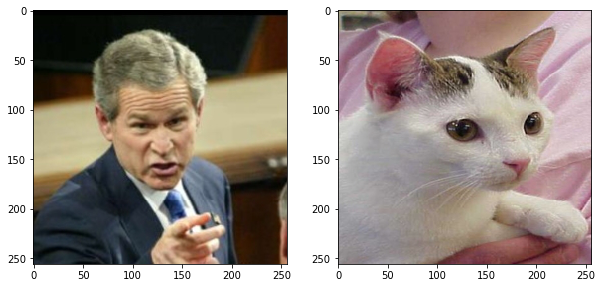

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(plt.imread(X_train[1]));
plt.subplot(122)
plt.imshow(plt.imread(X_train[0]));
plt.show()

In [6]:
class cnn_network(abstract_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
                layer = tf.layers.conv2d(inp, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
        
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 16, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
#                 layer = tf.layers.conv2d(layer, 16, , activation=tf.nn.relu)
#                 layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 256, activation=tf.nn.relu)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
#                 layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 3)

        return layer

Test accuracy: 82% 	Training loss: 0.7400160177046481 	 Training accuracy: 80% by 4th   
Test accuracy: 85% 	Training loss: 0.6933207230497027 	 Training accuracy: 85% by 10th

In [7]:
tf.reset_default_graph()
network = cnn_network(input_shape)
network.set_training_data(X_train, y_train, X_test, y_test)
network.training(batch_size=128, epochs=10, iter_before_validation=1)

32% of training is class 0
32% of training is class 1
34% of training is class 2
33% of test is class 0
31% of test is class 1
34% of test is class 2


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [04:10<00:00,  1.07it/s]


Epoch 1:
Test accuracy: 71% 	Training loss: 0.8730233896620658 	 Training accuracy: 64%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.44it/s]


Epoch 2:
Test accuracy: 79% 	Training loss: 0.7868453306336385 	 Training accuracy: 75%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.44it/s]


Epoch 3:
Test accuracy: 80% 	Training loss: 0.7686066239739885 	 Training accuracy: 77%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.41it/s]


Epoch 4:
Test accuracy: 84% 	Training loss: 0.7481928910907764 	 Training accuracy: 79%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.44it/s]


Epoch 5:
Test accuracy: 83% 	Training loss: 0.7351951317716263 	 Training accuracy: 80%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.47it/s]


Epoch 6:
Test accuracy: 84% 	Training loss: 0.7328637355322284 	 Training accuracy: 81%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.47it/s]


Epoch 7:
Test accuracy: 84% 	Training loss: 0.7163598521934569 	 Training accuracy: 82%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.46it/s]


Epoch 8:
Test accuracy: 85% 	Training loss: 0.7119416293158416 	 Training accuracy: 83%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.45it/s]


Epoch 9:
Test accuracy: 85% 	Training loss: 0.698904390671883 	 Training accuracy: 84%


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:49<00:00,  5.46it/s]


Epoch 10:
Test accuracy: 87% 	Training loss: 0.7094685537221265 	 Training accuracy: 83%


In [8]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' == op.name or 'features' == op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [9]:
network.freeze_model('frozen_models/model')

INFO:tensorflow:Froze 24 variables.
Converted 24 variables to const ops.
